In [1]:
import numpy as np
import cvxpy as cp # 用于凸优化求解
import matplotlib.pyplot as plt
import math

# 为了结果可复现
np.random.seed(7)

In [2]:
import mosek # 商业级凸优化求解器

In [3]:
from tqdm import tqdm # 进度条工具

In [4]:
# 检查已安装的求解器，并选择最佳可用求解器
_SOLVERS = cp.installed_solvers() # 获取cvxpy已安装的所有求解器
if "MOSEK" in _SOLVERS: # 如果MOSEK可用，则使用MOSEK（性能更好）
    SOLVER = "MOSEK"
else: # 否则回退使用SCS求解器
    SOLVER = "SCS"  # 备选求解器
print("Using solver:", SOLVER)

Using solver: MOSEK


In [5]:
# -------------------------
# Fock基辅助函数
# -------------------------
def destroy(d: int) -> np.ndarray:
    """创建Fock基下的单模湮灭算符a，维度为d×d
    参数：
    - d: 截断维度
    返回：
    - a: 湮灭算符矩阵
    """
    a = np.zeros((d, d), dtype=complex) # 初始化湮灭算符矩阵为零矩阵
    n = np.arange(1, d, dtype=float) # 创建从1到d-1的数组，用于计算a的系数
    a[:-1, 1:] = np.diag(np.sqrt(n)) # 在次对角线位置填充sqrt(n)，对应湮灭算符的性质
    return a

def create(d: int) -> np.ndarray:
    """创建Fock基下的产生算符a†，即湮灭算符的共轭转置
    参数：
    - d: 截断维度
    返回：
    - a†: 产生算符矩阵
    """
    return destroy(d).conj().T

def kron(*ops) -> np.ndarray:
    """计算多个算符的克罗内克积
    参数：
    - *ops: 任意数量的矩阵算符
    返回：
    - 所有算符按顺序的克罗内克积结果
    """
    out = np.array([[1+0j]]) # 初始化克罗内克积结果为1×1的复数单位矩阵
    for X in ops: # 按顺序对每个输入算符进行克罗内克积
        out = np.kron(out, X)
    return out

def partial_trace(rho: np.ndarray, dims, keep):
    """对量子态进行偏迹操作，保留指定子系统，剔除其他子系统
    参数：
    - rho: 密度矩阵
    - dims: 子系统维度列表，如[dA, dB]
    - keep: 要保留的子系统索引列表，如[1]表示保留B子系统
    返回：
    - 偏迹后的密度矩阵
    """
    dims = list(dims)  # 确保dims是列表类型
    N = len(dims) # 子系统数量
    keep = list(keep)  # 确保keep是列表类型
    trace = [i for i in range(N) if i not in keep]  # 计算要剔除的子系统索引
    # 将密度矩阵重塑为2N个指标
    rho_t = rho.reshape(*(dims + dims))
    # 重排指标，将保留的子系统移到前面
    idx_order = keep + trace + [N + i for i in keep] + [N + i for i in trace]
    rho_perm = rho_t.transpose(idx_order)
    # 计算保留子系统的总维度
    d_keep = int(np.prod([dims[i] for i in keep]))
    # 计算被剔除子系统的总维度
    d_trace = int(np.prod([dims[i] for i in trace])) if trace else 1
    # 重塑以准备偏迹运算
    rho_perm = rho_perm.reshape(d_keep, d_trace, d_keep, d_trace)
    # 执行偏迹运算，对被剔除子系统求和
    return np.einsum('ikjk->ij', rho_perm) # 使用爱因斯坦求和约定执行偏迹

In [6]:
# -------------------------
# TMS态（双模压缩真空态）和损耗信道
# -------------------------
def r_from_squeezing_db(s_db: float) -> float:
    """将压缩参数从dB转换为自然单位r
    参数：
    - s_db: 以dB为单位的压缩参数
    返回：
    - r: 自然单位的压缩参数
    """
    # s_db = 10 log10(e^{-2 r})  =>  r = -0.5 * ln(10**(s_db/10))
    return -0.5 * np.log(10**(s_db/10.0))

def tms_state_density(d: int, s_db: float) -> np.ndarray:
    """生成截断维度为d的双模压缩真空态密度矩阵
    TMS态形式：|psi> = sqrt(1-l^2) sum_n l^n |n,n>
    参数：
    - d: 截断维度
    - s_db: 压缩参数（dB）
    返回：
    - rho: TMS态密度矩阵
    """
    r = r_from_squeezing_db(s_db) # 将dB转换为自然单位r
    lam = np.tanh(r) # 计算lambda参数
    # 计算每个Fock态分量的振幅，每个Fock态的振幅为：sqrt(1-l^2) * lam^n
    amps = np.array([np.sqrt(1 - lam**2) * lam**n for n in range(d)], dtype=complex)
    psi = np.zeros((d*d,), dtype=complex) # 初始化态矢量
    for n in range(d):
        # 在|n,n>位置填充振幅
        psi[n*d + n] = amps[n]
    # 将态矢量转换为密度矩阵
    rho = np.outer(psi, psi.conj())
    return rho

def loss_kraus_1mode(d: int, eta: float):
    """生成单模纯损耗信道的Kraus算符
    Kraus算符形式：E_k |n> = sqrt(C(n,k)) (1-η)^{k/2} η^{(n-k)/2} |n-k>, n>=k
    参数：
    - d: 截断维度
    - eta: 传输效率
    返回：
    - Ks: Kraus算符列表
    """
    Ks = [] # 存储Kraus算符的列表
    for k in range(d): # 遍历所有可能的光子损失数量
        K = np.zeros((d, d), dtype=complex) # 初始化Kraus算符
        for n in range(k, d): # 对于每个可能的初始光子数
            # 计算系数：二项式系数、损耗因子和传输因子
            coeff = np.sqrt(math.comb(n, k) * (1-eta)**k * eta**(n-k))
            # 设置矩阵元素：从n光子态到n-k光子态的跃迁
            K[n-k, n] = coeff
        Ks.append(K) # 将生成的Kraus算符添加到列表中
    return Ks

def apply_symmetric_loss(rho_AB: np.ndarray, d: int, eta: float) -> np.ndarray:
    """对两体量子态应用对称损耗信道
    参数：
    - rho_AB: 两体密度矩阵
    - d: 单模截断维度
    - eta: 传输效率
    返回：
    - 应用损耗后的密度矩阵
    """
    # 为A和B子系统分别生成Kraus算符
    EA = loss_kraus_1mode(d, eta)
    EB = loss_kraus_1mode(d, eta)
    out = np.zeros_like(rho_AB, dtype=complex) # 初始化输出密度矩阵
    # 遍历所有可能的Kraus算符对
    for k in range(d):
        KA = EA[k] # A子系统的第k个Kraus算符
        for l in range(d):
            KB = EB[l] # B子系统的第l个Kraus算符
            K = kron(KA, KB) # 计算联合Kraus算符
            # 应用Kraus算符：K @ rho_AB @ K^†
            out += K @ rho_AB @ K.conj().T
    return out # 返回应用损耗后的密度矩阵

In [7]:
# -------------------------
# 正交算符和周期分箱POVM
# -------------------------
def quadrature_op(d: int, theta: float) -> np.ndarray:
    """创建角度为theta的正交算符x_theta
    定义：x_theta = (a e^{-iθ} + a† e^{iθ}) / sqrt(2)
    参数：
    - d: 截断维度
    - theta: 角度参数
    返回：
    - x_theta: 正交算符矩阵
    """
    a = destroy(d) # 获取湮灭算符
    adag = a.conj().T # 获取产生算符
    # 按照定义计算正交算符
    return (np.exp(-1j*theta)*a + np.exp(1j*theta)*adag) / np.sqrt(2.0)

def periodic_binning_povms(d: int, theta: float, T: float, o: int):
    """构建角度为theta的正交分量的周期分箱POVM测量算子
    步骤：
    1. 对角化x_θ
    2. 根据特征值模T分配到不同的箱子
    参数：
    - d: 截断维度
    - theta: 正交角度
    - T: 周期长度
    - o: 分箱数量
    返回：
    - Ms: POVM测量算子列表，每个为d×d半正定矩阵，总和≈单位矩阵
    """
    X = quadrature_op(d, theta) # 获取正交算符
    # 确保算符是厄米的（数值稳定性）
    Xh = 0.5*(X + X.conj().T)
    # 对角化，获取特征值和特征向量
    vals, vecs = np.linalg.eigh(Xh)
    # 计算每个分箱的宽度
    width = T / o
    # 计算特征值模T后的值，用于分配到不同的箱子
    mvals = np.mod(vals, T)
    # 确定每个特征值所属的箱子索引，确保索引在[0, o-1]范围内
    idxs = np.minimum((mvals / width).astype(int), o-1)

    Ms = [np.zeros((d, d), dtype=complex) for _ in range(o)] # 初始化POVM算子
    # 将每个特征向量投影到对应的箱子中
    for j in range(d):
        v = vecs[:, j:j+1] # 获取第j个特征向量
        Pj = v @ v.conj().T # 计算投影算符
        Ms[idxs[j]] += Pj # 将投影算符添加到对应的POVM算子中

    # 轻量级归一化，确保Σ_a M_a ≈ I
    S = sum(Ms) # 计算所有POVM算子的和
    # 使用伪逆进行"平衡"
    Sinv = np.linalg.pinv(S)
    Ms = [Sinv @ M @ Sinv.conj().T for M in Ms]
    return Ms # 返回POVM测量算子列表

In [8]:
# -------------------------
# 量子态集合（层析情况）
# -------------------------
def assemblage_tomography(rho_AB: np.ndarray, d: int, Tq: float, oA: int = 8):
    """生成Alice执行POVM测量后的量子态集合
    Alice的测量设置：x=0（θ=0，q正交），x=1（θ=π/2，p正交）
    量子态集合定义：σ_{a|x} = Tr_A[ (M_{a|x} ⊗ I) ρ_AB ]
    参数：
    - rho_AB: AB两体系统的密度矩阵
    - d: 截断维度
    - Tq: 周期分箱的周期长度
    - oA: Alice的POVM分箱数量，默认为8
    返回：
    - sigma_obs[x][a]: d×d半正定矩阵，表示在设置x下得到结果a时Bob的条件态
    """
    # Alice的两个测量设置对应的角度
    thetas = [0.0, np.pi/2]
    I_B = np.eye(d, dtype=complex) # Bob子系统的单位算符
    sigma = [] # 存储量子态集合
    # 对每个测量设置（x）
    for theta in thetas:
        # 生成该角度下的POVM测量算子
        Ms = periodic_binning_povms(d, theta, Tq, oA)
        row = [] # 存储该设置下所有结果对应的条件态
        # 对每个可能的测量结果（a）
        for Ma in Ms:
            # 计算 (M_a ⊗ I_B) ρ_AB (M_a ⊗ I_B)^†
            Tau = kron(Ma, I_B) @ rho_AB @ kron(Ma, I_B).conj().T
            # 对Alice子系统求偏迹，得到Bob的条件态
            sig = partial_trace(Tau, [d, d], keep=[1])  # 保留Bob子系统（索引1）
            row.append(sig)
        sigma.append(row)
    return sigma # 返回量子态集合

def normalize_per_x(sigma):
    """对量子态集合进行归一化，使得对于每个测量设置x，Σ_a Tr σ_{a|x} = 1
    参数：
    - sigma: 原始量子态集合
    返回：
    - out: 归一化后的量子态集合
    """
    out = [] # 存储归一化后的量子态集合
    # 对每个测量设置x
    for x in range(len(sigma)):
        # 计算该设置下所有结果的迹的总和
        total = sum(np.trace(sigma[x][a]).real for a in range(len(sigma[x])))
        # 对每个结果a，归一化其条件态
        out.append([sigma[x][a]/total for a in range(len(sigma[x]))])
    return out # 返回归一化后的量子态集合

In [9]:
# -------------------------
# 用于式(2)的半定规划（SDP）— 层析情况
# -------------------------
def guessing_prob_sdp_tomography(sigma_obs, x_star=0, solver=SOLVER, verbose=False):
    """求解Ioannou等人论文中式(2)的原始SDP问题，用于计算最优猜测概率
    SDP问题：
      maximize   Σ_e Tr[ σ_e[e|x*] ]  # 最大化Eve猜对的概率
      s.t.       Σ_e σ_e[a|x] = σ_obs[a|x]          (对所有a,x成立)
                 Σ_a σ_e[a|x] 与x无关               (无信号条件)
                 σ_e[a|x] ⪰ 0                      (半正定约束)
    参数：
    - sigma_obs[x][a]: d×d半正定矩阵，表示观测到的量子态集合
    - x_star: 固定的测量设置，默认为0
    - solver: 使用的SDP求解器
    - verbose: 是否显示求解过程信息
    返回：
    - val: 最优猜测概率值
    - status: 求解器状态
    """
    mX = len(sigma_obs)       # 测量设置数量，如2（q, p）
    mA = len(sigma_obs[0])    # 每个设置下的结果数量，如8个箱子
    d  = sigma_obs[0][0].shape[0] # 希尔伯特空间维度

    # 定义变量σ_e[a|x]，三维数组：[Eve猜测e][Alice结果a][Alice设置x]
    sigma_e = [[[cp.Variable((d, d), hermitian=True)
                 for _ in range(mX)] for _ in range(mA)] for _ in range(mA)]
    cons = [] # 存储约束条件

    # (i) 与观测到的量子态集合一致的约束
    for x in range(mX):
        for a in range(mA):
            # 对所有Eve猜测e求和，必须等于观测到的σ_obs[a|x]
            lhs = sum(sigma_e[e][a][x] for e in range(mA))
            cons.append(lhs == sigma_obs[x][a])

    # (ii) No-signalling on Eve side: Σ_a σ_e[a|x] = Σ_a σ_e[a|x'] (indep. of x)
    # (ii) Eve侧的无信号条件：Σ_a σ_e[a|x] 与x无关
    # 以e=0，x=0的边缘分布作为参考
    ref = sum(sigma_e[0][a][0] for a in range(mA))
    # 确保对于所有设置x，边缘分布都等于参考分布
    for x in range(mX):
        lhs = sum(sigma_e[0][a][x] for a in range(mA))
        cons.append(lhs == ref)

    # (iii) 半正定约束：所有σ_e[a|x]必须是半正定矩阵
    for e in range(mA):
        for x in range(mX):
            for a in range(mA):
                cons.append(sigma_e[e][a][x] >> 0)

    
    # 定义目标函数：最大化Eve猜对的概率，即当Eve猜测e且Alice结果也是e时的概率之和
    # 即最大化Tr[σ_e[e|x*] e^† e]
    obj = cp.Maximize(sum(cp.trace(sigma_e[e][e][x_star]) for e in range(mA)))
    # 构建优化问题
    prob = cp.Problem(obj, cons)
    # 求解问题
    val = prob.solve(solver=getattr(cp, solver), verbose=verbose)
    # 返回最优值和求解状态
    return float(val), prob.status

In [10]:
def reproduce_fig2_tomography(
    d=8,                # Fock空间截断维度（↑提高精度，↑增加运行时间）
    s_db=-4.0,           # 压缩参数（方差dB）
    eta_grid=np.linspace(0.55, 1.0, 10), # 效率η的扫描范围
    Tq_grid=np.linspace(2.0, 10.0, 9), # Alice的周期分箱大小T_q的扫描范围
    oA=8, # Alice的POVM分箱数量
    verbose=False # 是否显示求解器详细信息
):
    """
    复现Ioannou等人论文中的图2，扫描效率η并优化H_min关于Alice的周期分箱大小T_q
    参数：
    - d: Fock空间截断维度
    - s_db: 压缩参数
    - eta_grid: 效率η的扫描网格
    - Tq_grid: T_q的扫描网格
    - oA: Alice的POVM分箱数量
    - verbose: 是否显示详细信息
    返回：
    - Hmax[η]: 每个η对应的最大H_min值
    - Tbest[η]: 每个η对应的最优T_q值
    """
    Hmax = [] # 存储每个η对应的最大H_min
    Tbest = [] # 存储每个η对应的最优T_q

    # 外层循环：遍历不同的效率η，使用tqdm显示进度条
    for eta in tqdm(eta_grid, desc="Sweeping η", ncols=100):
        # 1) 构建TMS态并应用对称损耗
        rho0 = tms_state_density(d, s_db) # 生成初始TMS态
        rho  = apply_symmetric_loss(rho0, d, eta) # 应用损耗

        best_H = -np.inf # 初始化最佳H_min为负无穷
        best_T = None # 初始化最佳T_q为None

        # 2) 扫描Alice的周期分箱大小T_q
        for Tq in Tq_grid:
            # 生成量子态集合
            sigma = assemblage_tomography(rho, d, Tq, oA=oA)
            # 归一化量子态集合
            sigma = normalize_per_x(sigma)

            # 3) 求解SDP，得到猜测概率
            p_g, status = guessing_prob_sdp_tomography(
                sigma, x_star=0, solver=SOLVER, verbose=verbose
            )
            # 计算最小熵H_min = -log2(p_g)
            # 使用max(p_g, 1e-15)避免对极小值求对数导致数值问题
            H = -np.log2(max(p_g, 1e-15))

            # 更新最佳值
            if H > best_H:
                best_H, best_T = H, Tq
                
        # 存储当前η对应的最佳结果
        Hmax.append(best_H)
        Tbest.append(best_T)

        # 打印每个η的总结信息
        print(f"η={eta:.3f}: max H_min={best_H:.5f} at T_q={best_T:.2f}")
    # 返回结果数组
    return np.array(Hmax), np.array(Tbest)

In [11]:
# -------------------------
# 运行+绘制图2
# -------------------------
eta_grid = np.linspace(0.55, 1.0, 5) # 图2的η范围

d = 8

H_tomo, T_best = reproduce_fig2_tomography(
    d=d,
    s_db=-4.0, 
    eta_grid=eta_grid,
    Tq_grid=np.linspace(2.0, 10.0, 5),
    oA=8,
    verbose=False
)


Sweeping η:   0%|                                                             | 0/5 [00:00<?, ?it/s]/var/folders/hj/1q_k022n4zjbnjxn27_tb0ww0000gn/T/ipykernel_35186/2934552546.py:60: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(val), prob.status
Sweeping η:  20%|██████████▌                                          | 1/5 [01:38<06:35, 98.84s/it]

η=0.550: max H_min=0.00012 at T_q=6.00


Sweeping η:  40%|████████████████████▊                               | 2/5 [03:23<05:06, 102.07s/it]

η=0.663: max H_min=0.02834 at T_q=6.00


Sweeping η:  60%|███████████████████████████████▏                    | 3/5 [05:07<03:25, 102.92s/it]

η=0.775: max H_min=0.11498 at T_q=6.00


Sweeping η:  80%|█████████████████████████████████████████▌          | 4/5 [06:50<01:42, 102.97s/it]

η=0.887: max H_min=0.31184 at T_q=6.00


Sweeping η: 100%|████████████████████████████████████████████████████| 5/5 [08:30<00:00, 102.02s/it]

η=1.000: max H_min=0.91728 at T_q=10.00


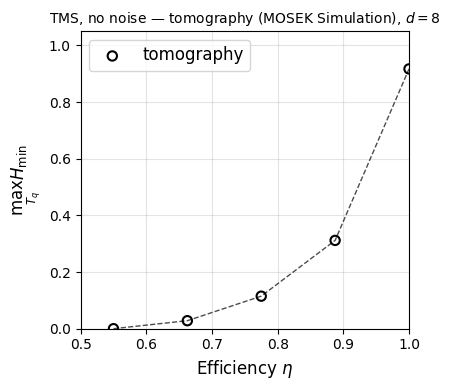

In [12]:
plt.figure(figsize=(4.4, 4.0))
plt.scatter(
    eta_grid, H_tomo, # 横轴为效率η，纵轴为最小熵H_min
    s=45, marker='o', facecolors='none', edgecolors='k', linewidths=1.5, # 设置散点样式
    label='tomography' # 图例标签
)

plt.plot(eta_grid, H_tomo, 'k--', lw=1, alpha=0.7) # 用虚线连接各点

plt.xlim(0.5, 1.0) # 设置x轴范围为[0.5, 1.0]
plt.ylim(0.0, 1.05) # 设置y轴范围为[0.0, 1.05]
plt.xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0]) # 设置x轴刻度
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) # 设置y轴刻度
plt.grid(True, alpha=0.35) # 显示网格线

plt.xlabel(r'Efficiency $\eta$', fontsize=12) # 设置x轴标签，字体大小为12
plt.ylabel(r'$\max_{T_q} H_{\min}$', fontsize=12) # 设置y轴标签，字体大小为12
plt.title(f'TMS, no noise — tomography (MOSEK Simulation), $d={d}$', fontsize=10) # 设置标题，字体大小为10
plt.legend(loc='upper left', frameon=True, fontsize=12) # 设置图例，字体大小为12
plt.tight_layout() # 调整布局
plt.show()

In [13]:
def nonperiodic_binning_povms(d, theta, o, r):
    """
    Bob的非周期性分箱同态测量POVM算子构建函数
    用于在角度theta处对正交分量进行o个分箱的测量，分箱范围为[-r, r]
    小于-r的值被归入第一个分箱，大于r的值被归入最后一个分箱
    通过在截断的Fock空间中对角化x_theta并按分箱分组特征模式来实现
    
    参数：
    - d: 截断维度
    - theta: 正交测量角度
    - o: 分箱数量
    - r: 分箱范围的半径
    
    返回：
    - Ns: POVM测量算子列表，每个为d×d半正定矩阵，总和≈单位矩阵
    """
    # 获取角度为theta的正交算符
    X = quadrature_op(d, theta)
    # 确保算符是厄米的（数值稳定性）
    Xh = 0.5*(X + X.conj().T)
    # 对角化，获取特征值和特征向量
    vals, vecs = np.linalg.eigh(Xh)
    
    # 计算分箱的边界，从-r到r分为o+1个边界点
    edges = np.linspace(-r, r, o+1)
    # 确定每个特征值所属的分箱索引，使用searchsorted找到应该插入的位置
    # side='right'表示使用右边界，即vals <= edges[idx] < vals+1
    idxs = np.searchsorted(edges, vals, side='right') - 1
    # 确保索引在[0, o-1]范围内，超出范围的被截断到最近的边界
    idxs = np.clip(idxs, 0, o-1)

    # 初始化POVM算子列表
    Ns = [np.zeros((d, d), dtype=complex) for _ in range(o)]
    # 将每个特征向量投影到对应的分箱中
    for j in range(d):
        v = vecs[:, j:j+1] # 获取第j个特征向量
        Pj = v @ v.conj().T # 计算投影算符
        Ns[idxs[j]] += Pj # 将投影算符添加到对应的POVM算子中

    # 轻量级归一化，确保Σ_b N_{b|y} ≈ I
    S = sum(Ns) # 计算所有POVM算子的和
    Sinv = np.linalg.pinv(S) # 计算伪逆
    # 使用伪逆进行归一化处理
    Ns = [Sinv @ N @ Sinv.conj().T for N in Ns]
    return Ns

def estimate_range_r(rho_AB, d):
    """
    从Bob的x正交分量的二阶矩估计一个合理的有限分箱范围r
    使用theta=0（q正交）并设置r≈6*sigma_x以覆盖大部分概率质量
    
    参数：
    - rho_AB: AB两体系统的密度矩阵
    - d: 截断维度
    
    返回：
    - r: 估计的分箱范围半径
    """
    # 获取q正交算符（theta=0）
    X0 = quadrature_op(d, 0.0)
    # Alice子系统的单位算符
    I_A = np.eye(d, dtype=complex)
    # 构建联合系统的正交算符
    X_op = kron(I_A, X0)
    # 计算均值
    mean = np.real(np.trace(X_op @ rho_AB))
    # 计算方差 = <X²> - <X>²
    var  = np.real(np.trace((X_op @ X_op) @ rho_AB)) - mean**2
    # 计算标准差，确保不小于极小值避免数值问题
    sigma = np.sqrt(max(var, 1e-12))
    # 返回6倍标准差作为分箱范围半径，确保覆盖大部分概率
    return 6.0 * sigma

In [14]:
def joint_probabilities(rho_AB, M_ax_list, N_by_list):
    """
    计算联合概率P[a,b,x,y] = Tr[(M_{a|x} ⊗ N_{b|y}) ρ_AB]
    其中M_ax_list[x][a]和N_by_list[y][b]分别是Alice和Bob的POVM元素
    
    参数：
    - rho_AB: AB两体系统的密度矩阵
    - M_ax_list: Alice的POVM测量算子列表，M_ax_list[x][a]表示设置x下结果a的测量算子
    - N_by_list: Bob的POVM测量算子列表，N_by_list[y][b]表示设置y下结果b的测量算子
    
    返回：
    - P: 四维数组，形状为(mX, oA, mB, oB)，表示联合概率
    """
    # 获取测量设置数量和结果数量
    mX = len(M_ax_list) # Alice的测量设置数量
    oA = len(M_ax_list[0]) # Alice每个设置下的结果数量
    mB = len(N_by_list) # Bob的测量设置数量
    oB = len(N_by_list[0]) # Bob每个设置下的结果数量
    
    # 初始化联合概率数组
    P = np.zeros((mX, oA, mB, oB))
    # 遍历所有可能的设置和结果组合
    for x in range(mX): # Alice的测量设置
        for a in range(oA): # Alice的测量结果
            Ma = M_ax_list[x][a] # 获取Alice的测量算子
            for y in range(mB): # Bob的测量设置
                for b in range(oB): # Bob的测量结果
                    Nb = N_by_list[y][b] # 获取Bob的测量算子
                    K = kron(Ma, Nb) # 计算Alice和Bob的测量算子的直积
                    P[x, a, y, b] = np.real(np.trace(K @ rho_AB)) # 计算联合概率，Tr[K @ rho_AB]，并取实部
    return P

In [15]:
# -------------------------
# 同态测量情况下的猜测概率SDP求解
# -------------------------
def guessing_prob_sdp_homodyne(P, N_by_list, x_star=0, solver=None, verbose=False,
                               mosek_params=None, scs_params=None):
    """
    当Bob使用m_B个同态POVM（分箱）时，求解Eve的猜测概率的半定规划(SDP)
    
    SDP问题：
      maximize   sum_e Tr( sigma_e[e|x*] )  # 最大化Eve猜对的概率
      s.t.       sum_e Tr( N_{b|y} * sigma_e[a|x] ) = P[a,b,x,y]   ∀ a,b,x,y
                 sum_a sigma_e[a|x] 与x无关               (无信号条件)
                 sigma_e[a|x] ≥ 0                       (半正定约束)
    
    参数：
    - P: 四维数组，形状为(mX, oA, mB, oB)，表示联合概率
    - N_by_list: Bob的POVM测量算子列表，每个为d×d半正定矩阵
    - x_star: 固定的测量设置，默认为0
    - solver: 使用的SDP求解器，默认使用全局SOLVER或SCS
    - verbose: 是否显示求解过程信息
    - mosek_params: MOSEK求解器的参数
    - scs_params: SCS求解器的参数
    
    返回：
    - val: 最优猜测概率值
    - status: 求解器状态
    """
    if solver is None:
        # 尝试使用全局定义的SOLVER，如果不存在则使用SCS
        try:
            from builtins import SOLVER as _S
            solver = _S
        except Exception:
            solver = "SCS"

    # 获取概率数组的维度和希尔伯特空间维度
    mX, oA, mB, oB = P.shape
    d = N_by_list[0][0].shape[0]

    # # 定义变量σ_e[a|x] ∈ C^{d×d}，三维数组：[Eve猜测e][Alice结果a][Alice设置x]，且 e ∈ {0,...,oA-1}
    sigma_e = [[[cp.Variable((d, d), hermitian=True)
                 for _ in range(mX)] for _ in range(oA)] for _ in range(oA)]
    cons = []

    # (i) 通过Bob的POVM实现概率匹配约束
    for x in range(mX): # Alice的测量设置
        for a in range(oA): # Alice的测量结果
            Sig_ax = sum(sigma_e[e][a][x] for e in range(oA))  # Σ_e σ_e[a|x]，对所有Eve猜测求和
            for y in range(mB): # Bob的测量设置
                for b in range(oB): # Bob的测量结果
                    Nb = N_by_list[y][b] # 获取Bob的POVM算子
                    # 约束条件：Tr[Nb @ Sig_ax] = P[x,a,y,b]
                    cons.append(cp.real(cp.trace(Nb @ Sig_ax)) == P[x, a, y, b])

    # (ii) Eve侧的无信号条件：Σ_a σ_e[a|x] 与x无关
    # 以e=0，x=0的边缘分布作为参考
    ref = sum(sigma_e[0][a][0] for a in range(oA))
    # 确保对于所有设置x，边缘分布都等于参考分布
    for x in range(mX):
        lhs = sum(sigma_e[0][a][x] for a in range(oA))
        cons.append(lhs == ref)

    # (iii) 半正定约束：所有σ_e[a|x]必须是半正定矩阵
    for e in range(oA): # Eve的猜测
        for x in range(mX): # Alice的测量设置
            for a in range(oA): # Alice的测量结果
                cons.append(sigma_e[e][a][x] >> 0)

    # 定义目标函数：最大化Eve猜对的概率，即当Eve猜测e且Alice结果也是e时的概率之和
    obj = cp.Maximize(sum(cp.trace(sigma_e[e][e][x_star]) for e in range(oA)))
    # 构建优化问题
    prob = cp.Problem(obj, cons)

    # 根据选择的求解器进行求解
    if solver == "MOSEK":
        # 使用MOSEK求解器，并设置参数
        val = prob.solve(solver=cp.MOSEK, verbose=verbose,
                         mosek_params=(mosek_params or {
                             "MSK_DPAR_INTPNT_CO_TOL_REL_GAP": 1e-3, # 相对间隙公差
                             "MSK_DPAR_INTPNT_CO_TOL_PFEAS": 1e-6, # 原始可行性公差
                             "MSK_DPAR_INTPNT_CO_TOL_DFEAS": 1e-6, # 对偶可行性公差
                         }))
    elif solver == "SCS":
        # 使用SCS求解器，并设置参数
        val = prob.solve(solver=cp.SCS, verbose=verbose,
                         **(scs_params or {"eps": 1e-3, "max_iters": 5000}))
    else:
        # 使用其他求解器
        val = prob.solve(solver=getattr(cp, solver), verbose=verbose)
    # 返回最优值（确保为实数）和求解状态
    return float(np.real_if_close(val)), prob.status

In [16]:
# -------------------------
# 复现论文图2 - 同态测量情况（Bob使用2个测量设置）
# -------------------------
def reproduce_fig2_homodyne_mb2(
    d=8,                         # Fock空间截断维度（提高到10-12可获得更接近的匹配）
    s_db=-4.0,                   # 压缩参数（dB）
    eta_grid=np.linspace(0.55, 1.0, 5), # 效率η的扫描范围
    Tq_grid=np.linspace(2.0, 10.0, 5),  # Alice的周期分箱大小T_q的扫描范围
    oA=8,                        # Alice的周期分箱数量
    oB=16,                       # Bob的非周期分箱数量
    verbose=False                # 是否显示详细信息
):
    """
    复现Ioannou等人论文中的图2，使用同态测量，Bob使用2个测量设置
    扫描效率η并优化H_min关于Alice的周期分箱大小T_q
    
    参数：
    - d: Fock空间截断维度
    - s_db: 压缩参数
    - eta_grid: 效率η的扫描网格
    - Tq_grid: T_q的扫描网格
    - oA: Alice的POVM分箱数量
    - oB: Bob的POVM分箱数量
    - verbose: 是否显示详细信息
    
    返回：
    - Hmax[η]: 每个η对应的最大H_min值
    - Tbest[η]: 每个η对应的最优T_q值
    """
    # Bob's angles for m_B=2，q和p正交
    thetas_B = [0.0, np.pi/2]
    Hmax, Tbest = [], [] # 存储每个η对应的最大H_min，存储每个η对应的最优T_q

    # 遍历不同的效率η
    for eta in eta_grid:
        # 1) 构建TMS态并应用对称损耗
        rho0 = tms_state_density(d, s_db) # 生成初始TMS态
        rho  = apply_symmetric_loss(rho0, d, eta) # 应用损耗

        # 2) 为Bob的非周期性分箱选择有限范围
        r = estimate_range_r(rho, d)

        # 3) 预构建Bob的POVMs {N_{b|y}}，使用m_B=2个测量设置
        N_by_list = [nonperiodic_binning_povms(d, th, oB, r) for th in thetas_B]

        best_H, best_T = -np.inf, None # 初始化最佳值

        # 4) 扫描Alice的周期分箱大小T_q
        for Tq in Tq_grid:
            # Alice的周期分箱POVMs（层析设置），构建M_{a|x}
            thetas_A = [0.0, np.pi/2] # Alice的两个测量设置角度
            M_ax_list = [periodic_binning_povms(d, th, Tq, oA) for th in thetas_A]

            # 5) 计算联合概率P[a,b,x,y]
            P = joint_probabilities(rho, M_ax_list, N_by_list)

            # 6) 使用概率约束求解SDP
            p_g, status = guessing_prob_sdp_homodyne(
                P, N_by_list, x_star=0, solver=SOLVER, verbose=verbose
            )
            # 计算最小熵H_min = -log2(p_g)
            H = -np.log2(max(p_g, 1e-15)) # 使用max避免对极小值求对数导致数值问题
            if H > best_H:
                best_H, best_T = H, Tq

        # 存储当前η对应的最佳结果
        Hmax.append(best_H)
        Tbest.append(best_T)
        # 打印每个η的总结信息
        print(f"η={eta:.3f}: m_B=2  max H_min={best_H:.4f} at T_q={best_T:.2f}")

    # 返回结果数组
    return np.array(Hmax), np.array(Tbest)

In [17]:
eta_grid = np.linspace(0.55, 1.0, 5)

H_mb2, Tbest_mb2 = reproduce_fig2_homodyne_mb2(
    d=8, s_db=-4.0,
    eta_grid=eta_grid,
    Tq_grid=np.linspace(2.0, 10.0, 5),
    oA=6, oB=12,
    verbose=False
)

η=0.550: m_B=2  max H_min=-0.0000 at T_q=4.00
η=0.663: m_B=2  max H_min=-0.0000 at T_q=10.00
η=0.775: m_B=2  max H_min=0.0222 at T_q=8.00
η=0.887: m_B=2  max H_min=0.0967 at T_q=8.00
η=1.000: m_B=2  max H_min=0.4555 at T_q=4.00


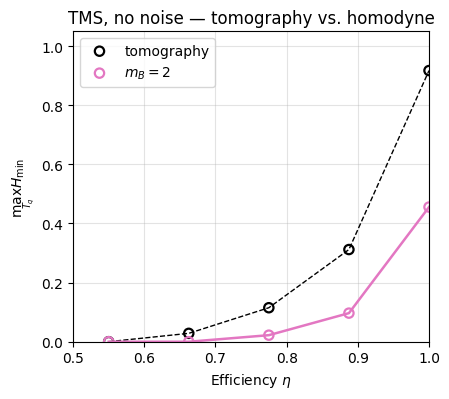

In [18]:
plt.figure(figsize=(4.6, 4.1))

plt.scatter(
    eta_grid, H_tomo,
    s=45, marker='o', facecolors='none', edgecolors='k', linewidths=1.6,
    label='tomography'
)
plt.plot(eta_grid, H_tomo, 'k--', lw=1)
plt.scatter(
    eta_grid, H_mb2,
    s=45, marker='o', facecolors='none', edgecolors='tab:pink', linewidths=1.6,
    label=r'$m_B=2$'
)
plt.plot(eta_grid, H_mb2, color='tab:pink', lw=1.8)

plt.xlim(0.5, 1.0)
plt.ylim(0.0, 1.05)
plt.xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.grid(True, alpha=0.35)

plt.xlabel(r'Efficiency $\eta$')
plt.ylabel(r'$\max_{T_q} H_{\min}$')
plt.title('TMS, no noise — tomography vs. homodyne')
plt.legend(loc='upper left', frameon=True)

plt.tight_layout()
plt.show()

In [19]:
# 遍历不同维度d，获取H_min结果集合
d_values = range(3, 11)  # d从3到10
H_tomo_results = {}  # 存储每个d对应的结果
T_best_results = {}  # 存储每个d对应的最优T_q

# 设置固定的参数
eta_grid = np.linspace(0.55, 1.0, 10)  # 与原始代码保持一致
Tq_grid = np.linspace(2.0, 10.0, 9)   # 与原始代码保持一致

print("开始遍历不同维度d...")
for d in d_values:
    print(f"正在处理 d = {d}...")
    try:
        H_tomo, T_best = reproduce_fig2_tomography(
            d=d,
            s_db=-4.0,
            eta_grid=eta_grid,
            Tq_grid=Tq_grid,
            oA=8,
            verbose=False
        )
        H_tomo_results[d] = H_tomo
        T_best_results[d] = T_best
        print(f"d = {d} 完成，最大H_min = {np.max(H_tomo):.4f}")
    except Exception as e:
        print(f"d = {d} 处理失败: {e}")
        H_tomo_results[d] = None
        T_best_results[d] = None

print("所有维度处理完成！")

开始遍历不同维度d...
正在处理 d = 3...


Sweeping η:   0%|                                                            | 0/10 [00:00<?, ?it/s]/var/folders/hj/1q_k022n4zjbnjxn27_tb0ww0000gn/T/ipykernel_35186/2934552546.py:60: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(val), prob.status
Sweeping η:  10%|█████▏                                              | 1/10 [00:26<04:01, 26.82s/it]

η=0.550: max H_min=-0.00000 at T_q=10.00


Sweeping η:  20%|██████████▍                                         | 2/10 [00:53<03:35, 26.98s/it]

η=0.600: max H_min=-0.00000 at T_q=10.00


Sweeping η:  30%|███████████████▌                                    | 3/10 [01:21<03:09, 27.09s/it]

η=0.650: max H_min=0.00092 at T_q=10.00


Sweeping η:  40%|████████████████████▊                               | 4/10 [01:48<02:43, 27.17s/it]

η=0.700: max H_min=0.01309 at T_q=10.00


Sweeping η:  50%|██████████████████████████                          | 5/10 [02:15<02:15, 27.18s/it]

η=0.750: max H_min=0.03062 at T_q=10.00


Sweeping η:  60%|███████████████████████████████▏                    | 6/10 [02:42<01:48, 27.24s/it]

η=0.800: max H_min=0.05418 at T_q=10.00


Sweeping η:  70%|████████████████████████████████████▍               | 7/10 [03:10<01:21, 27.31s/it]

η=0.850: max H_min=0.08583 at T_q=10.00


Sweeping η:  80%|█████████████████████████████████████████▌          | 8/10 [03:37<00:54, 27.31s/it]

η=0.900: max H_min=0.13204 at T_q=10.00


Sweeping η:  90%|██████████████████████████████████████████████▊     | 9/10 [04:05<00:27, 27.30s/it]

η=0.950: max H_min=0.20494 at T_q=10.00


Sweeping η: 100%|███████████████████████████████████████████████████| 10/10 [04:32<00:00, 27.23s/it]


η=1.000: max H_min=0.36218 at T_q=10.00
d = 3 完成，最大H_min = 0.3622
正在处理 d = 4...


Sweeping η:  10%|█████▏                                              | 1/10 [00:45<06:53, 45.96s/it]

η=0.550: max H_min=0.00023 at T_q=7.00


Sweeping η:  20%|██████████▍                                         | 2/10 [01:32<06:09, 46.20s/it]

η=0.600: max H_min=0.01316 at T_q=7.00


Sweeping η:  30%|███████████████▌                                    | 3/10 [02:18<05:23, 46.20s/it]

η=0.650: max H_min=0.03663 at T_q=7.00


Sweeping η:  40%|████████████████████▊                               | 4/10 [03:04<04:36, 46.16s/it]

η=0.700: max H_min=0.07548 at T_q=7.00


Sweeping η:  50%|██████████████████████████                          | 5/10 [03:51<03:51, 46.24s/it]

η=0.750: max H_min=0.13217 at T_q=7.00


Sweeping η:  60%|███████████████████████████████▏                    | 6/10 [04:36<03:04, 46.12s/it]

η=0.800: max H_min=0.20860 at T_q=5.00


Sweeping η:  70%|████████████████████████████████████▍               | 7/10 [05:22<02:18, 46.11s/it]

η=0.850: max H_min=0.30688 at T_q=7.00


Sweeping η:  80%|█████████████████████████████████████████▌          | 8/10 [06:09<01:32, 46.08s/it]

η=0.900: max H_min=0.42971 at T_q=7.00


Sweeping η:  90%|██████████████████████████████████████████████▊     | 9/10 [06:55<00:46, 46.13s/it]

η=0.950: max H_min=0.58257 at T_q=7.00


Sweeping η: 100%|███████████████████████████████████████████████████| 10/10 [07:41<00:00, 46.14s/it]


η=1.000: max H_min=0.76310 at T_q=7.00
d = 4 完成，最大H_min = 0.7631
正在处理 d = 5...


Sweeping η:  10%|█████▏                                              | 1/10 [01:10<10:36, 70.72s/it]

η=0.550: max H_min=0.00253 at T_q=6.00


Sweeping η:  20%|██████████▍                                         | 2/10 [02:22<09:30, 71.26s/it]

η=0.600: max H_min=0.02003 at T_q=5.00


Sweeping η:  30%|███████████████▌                                    | 3/10 [03:33<08:18, 71.20s/it]

η=0.650: max H_min=0.04419 at T_q=4.00


Sweeping η:  40%|████████████████████▊                               | 4/10 [04:44<07:06, 71.12s/it]

η=0.700: max H_min=0.08181 at T_q=6.00


Sweeping η:  50%|██████████████████████████                          | 5/10 [05:55<05:54, 70.97s/it]

η=0.750: max H_min=0.14051 at T_q=5.00


Sweeping η:  60%|███████████████████████████████▏                    | 6/10 [07:06<04:44, 71.05s/it]

η=0.800: max H_min=0.22611 at T_q=6.00


Sweeping η:  70%|████████████████████████████████████▍               | 7/10 [08:17<03:33, 71.08s/it]

η=0.850: max H_min=0.34249 at T_q=6.00


Sweeping η:  80%|█████████████████████████████████████████▌          | 8/10 [09:28<02:22, 71.17s/it]

η=0.900: max H_min=0.49218 at T_q=4.00


Sweeping η:  90%|██████████████████████████████████████████████▊     | 9/10 [10:40<01:11, 71.33s/it]

η=0.950: max H_min=0.67436 at T_q=5.00


Sweeping η:  90%|██████████████████████████████████████████████▊     | 9/10 [10:56<01:12, 72.96s/it]


d = 5 处理失败: Solver 'MOSEK' failed. Try another solver, or solve with verbose=True for more information.
正在处理 d = 6...


Sweeping η:  10%|█████                                              | 1/10 [01:41<15:12, 101.34s/it]

η=0.550: max H_min=0.00071 at T_q=4.00


Sweeping η:  20%|██████████▏                                        | 2/10 [03:23<13:32, 101.53s/it]

η=0.600: max H_min=0.01025 at T_q=7.00


Sweeping η:  30%|███████████████▎                                   | 3/10 [05:04<11:51, 101.62s/it]

η=0.650: max H_min=0.02927 at T_q=4.00


Sweeping η:  40%|████████████████████▍                              | 4/10 [06:46<10:09, 101.57s/it]

η=0.700: max H_min=0.06012 at T_q=5.00


Sweeping η:  50%|█████████████████████████▌                         | 5/10 [08:27<08:27, 101.42s/it]

η=0.750: max H_min=0.10832 at T_q=4.00


Sweeping η:  60%|██████████████████████████████▌                    | 6/10 [10:08<06:45, 101.26s/it]

η=0.800: max H_min=0.17756 at T_q=7.00


Sweeping η:  70%|███████████████████████████████████▋               | 7/10 [11:50<05:04, 101.44s/it]

η=0.850: max H_min=0.27104 at T_q=5.00


Sweeping η:  80%|████████████████████████████████████████▊          | 8/10 [13:32<03:23, 101.59s/it]

η=0.900: max H_min=0.38923 at T_q=6.00


Sweeping η:  90%|█████████████████████████████████████████████▉     | 9/10 [15:13<01:41, 101.59s/it]

η=0.950: max H_min=0.52591 at T_q=6.00


Sweeping η: 100%|██████████████████████████████████████████████████| 10/10 [16:54<00:00, 101.44s/it]


η=1.000: max H_min=0.64320 at T_q=4.00
d = 6 完成，最大H_min = 0.6432
正在处理 d = 7...


Sweeping η:  10%|█████                                              | 1/10 [02:16<20:29, 136.60s/it]

η=0.550: max H_min=0.00023 at T_q=4.00


Sweeping η:  20%|██████████▏                                        | 2/10 [04:38<18:39, 139.88s/it]

η=0.600: max H_min=0.01346 at T_q=5.00


Sweeping η:  30%|███████████████▎                                   | 3/10 [07:04<16:38, 142.64s/it]

η=0.650: max H_min=0.03415 at T_q=2.00


Sweeping η:  40%|████████████████████▍                              | 4/10 [09:25<14:10, 141.72s/it]

η=0.700: max H_min=0.06551 at T_q=6.00


Sweeping η:  50%|█████████████████████████▌                         | 5/10 [11:42<11:41, 140.33s/it]

η=0.750: max H_min=0.11482 at T_q=4.00


Sweeping η:  60%|██████████████████████████████▌                    | 6/10 [14:02<09:20, 140.14s/it]

η=0.800: max H_min=0.18748 at T_q=5.00


Sweeping η:  70%|███████████████████████████████████▋               | 7/10 [16:20<06:58, 139.35s/it]

η=0.850: max H_min=0.29031 at T_q=6.00


Sweeping η:  80%|████████████████████████████████████████▊          | 8/10 [18:42<04:40, 140.19s/it]

η=0.900: max H_min=0.42388 at T_q=4.00


Sweeping η:  90%|█████████████████████████████████████████████▉     | 9/10 [21:13<02:23, 143.54s/it]

η=0.950: max H_min=0.57270 at T_q=2.00


Sweeping η: 100%|██████████████████████████████████████████████████| 10/10 [23:30<00:00, 141.01s/it]


η=1.000: max H_min=0.69681 at T_q=3.00
d = 7 完成，最大H_min = 0.6968
正在处理 d = 8...


Sweeping η:  10%|█████                                              | 1/10 [02:59<26:56, 179.66s/it]

η=0.550: max H_min=0.00012 at T_q=6.00


Sweeping η:  20%|██████████▏                                        | 2/10 [06:01<24:06, 180.83s/it]

η=0.600: max H_min=0.00712 at T_q=6.00


Sweeping η:  30%|███████████████▎                                   | 3/10 [09:12<21:38, 185.45s/it]

η=0.650: max H_min=0.02335 at T_q=6.00


Sweeping η:  40%|████████████████████▍                              | 4/10 [12:22<18:43, 187.32s/it]

η=0.700: max H_min=0.04816 at T_q=6.00


Sweeping η:  50%|█████████████████████████▌                         | 5/10 [15:28<15:34, 186.90s/it]

η=0.750: max H_min=0.08794 at T_q=6.00


Sweeping η:  60%|██████████████████████████████▌                    | 6/10 [18:41<12:36, 189.06s/it]

η=0.800: max H_min=0.14745 at T_q=6.00


Sweeping η:  70%|███████████████████████████████████▋               | 7/10 [21:52<09:28, 189.44s/it]

η=0.850: max H_min=0.23204 at T_q=6.00


Sweeping η:  80%|████████████████████████████████████████▊          | 8/10 [25:02<06:19, 189.60s/it]

η=0.900: max H_min=0.34123 at T_q=6.00


Sweeping η:  90%|█████████████████████████████████████████████▉     | 9/10 [28:15<03:10, 190.67s/it]

η=0.950: max H_min=0.49038 at T_q=10.00


Sweeping η: 100%|██████████████████████████████████████████████████| 10/10 [31:14<00:00, 187.45s/it]


η=1.000: max H_min=0.91728 at T_q=10.00
d = 8 完成，最大H_min = 0.9173
正在处理 d = 9...


Sweeping η:  10%|█████                                              | 1/10 [03:47<34:03, 227.04s/it]

η=0.550: max H_min=-0.00000 at T_q=9.00


Sweeping η:  20%|██████████▏                                        | 2/10 [07:35<30:24, 228.12s/it]

η=0.600: max H_min=0.00073 at T_q=9.00


Sweeping η:  30%|███████████████▎                                   | 3/10 [11:25<26:42, 228.96s/it]

η=0.650: max H_min=0.00655 at T_q=7.00


Sweeping η:  40%|████████████████████▍                              | 4/10 [15:16<22:58, 229.68s/it]

η=0.700: max H_min=0.02089 at T_q=7.00


Sweeping η:  50%|█████████████████████████▌                         | 5/10 [19:09<19:14, 230.80s/it]

η=0.750: max H_min=0.04594 at T_q=7.00


Sweeping η:  60%|██████████████████████████████▌                    | 6/10 [23:01<15:24, 231.11s/it]

η=0.800: max H_min=0.08563 at T_q=7.00


Sweeping η:  70%|███████████████████████████████████▋               | 7/10 [26:52<11:33, 231.19s/it]

η=0.850: max H_min=0.14436 at T_q=7.00


Sweeping η:  80%|████████████████████████████████████████▊          | 8/10 [30:45<07:43, 231.75s/it]

η=0.900: max H_min=0.22278 at T_q=7.00


Sweeping η:  90%|█████████████████████████████████████████████▉     | 9/10 [34:36<03:51, 231.59s/it]

η=0.950: max H_min=0.31161 at T_q=7.00


Sweeping η: 100%|██████████████████████████████████████████████████| 10/10 [38:24<00:00, 230.42s/it]


η=1.000: max H_min=0.39282 at T_q=9.00
d = 9 完成，最大H_min = 0.3928
正在处理 d = 10...


Sweeping η:  10%|█████                                              | 1/10 [04:42<42:21, 282.42s/it]

η=0.550: max H_min=0.00001 at T_q=7.00


Sweeping η:  20%|█████████▊                                       | 2/10 [15:12<1:04:57, 487.17s/it]

η=0.600: max H_min=0.00372 at T_q=3.00


Sweeping η:  30%|███████████████▎                                   | 3/10 [20:07<46:35, 399.36s/it]

η=0.650: max H_min=0.01718 at T_q=3.00


Sweeping η:  40%|████████████████████▍                              | 4/10 [25:05<35:55, 359.28s/it]

η=0.700: max H_min=0.03618 at T_q=6.00


Sweeping η:  50%|█████████████████████████▌                         | 5/10 [30:06<28:11, 338.28s/it]

η=0.750: max H_min=0.06699 at T_q=7.00


Sweeping η:  60%|██████████████████████████████▌                    | 6/10 [35:06<21:40, 325.15s/it]

η=0.800: max H_min=0.11875 at T_q=7.00


Sweeping η:  70%|███████████████████████████████████▋               | 7/10 [40:07<15:51, 317.25s/it]

η=0.850: max H_min=0.19470 at T_q=7.00


Sweeping η:  80%|████████████████████████████████████████▊          | 8/10 [45:05<10:22, 311.10s/it]

η=0.900: max H_min=0.29604 at T_q=7.00


Sweeping η:  90%|█████████████████████████████████████████████▉     | 9/10 [50:04<05:07, 307.54s/it]

η=0.950: max H_min=0.45573 at T_q=9.00


Sweeping η: 100%|██████████████████████████████████████████████████| 10/10 [54:54<00:00, 329.44s/it]

η=1.000: max H_min=0.87103 at T_q=9.00
d = 10 完成，最大H_min = 0.8710
所有维度处理完成！


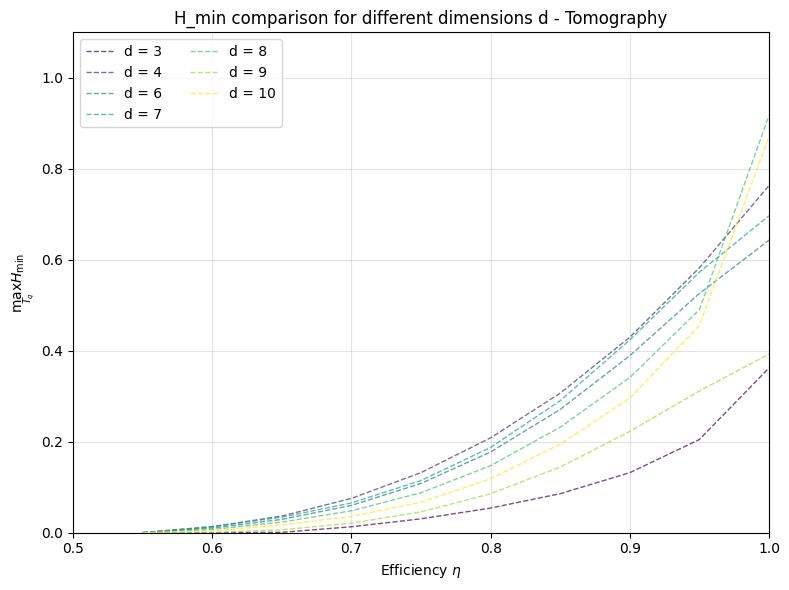

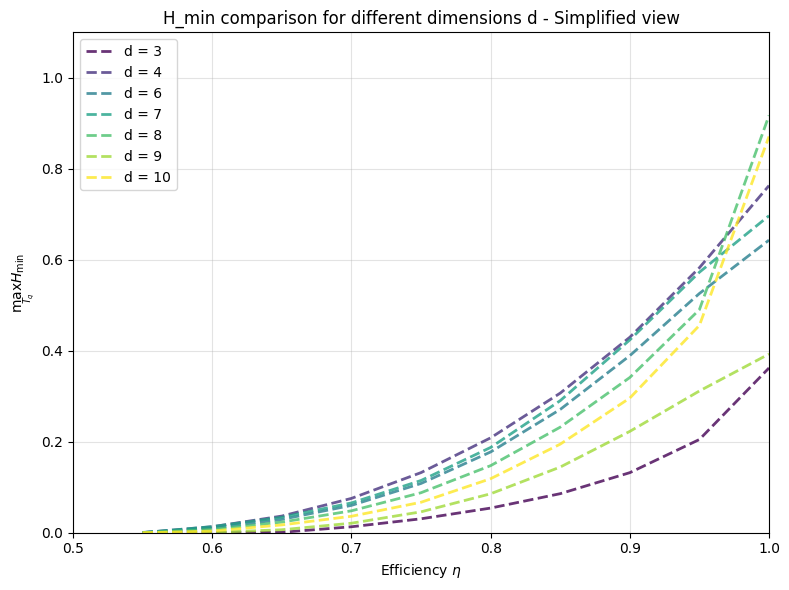

In [21]:
# 绘制不同维度d的结果对比图
plt.figure(figsize=(8, 6))

# 定义颜色映射
colors = plt.cm.viridis(np.linspace(0, 1, len(d_values)))

# 绘制每条曲线
for i, d in enumerate(d_values):
    if H_tomo_results[d] is not None:
        plt.plot(eta_grid, H_tomo_results[d], '--', 
                color=colors[i], lw=1, alpha=0.7, 
                label=f'd = {d}')

# 设置图形属性
plt.xlim(0.5, 1.0)
plt.ylim(0.0, 1.1)  # 稍微增加y轴范围以容纳所有曲线
plt.xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.grid(True, alpha=0.35)

plt.xlabel(r'Efficiency $\eta$')
plt.ylabel(r'$\max_{T_q} H_{\min}$')
plt.title('H_min comparison for different dimensions d - Tomography')

# 添加图例
plt.legend(loc='upper left', frameon=True, ncol=2)

plt.tight_layout()
plt.show()

# 也可以创建一个简化的图例，只显示部分维度
plt.figure(figsize=(8, 6))
selected_d = [3, 4, 5, 6, 7, 8, 9, 10]  # 选择部分维度显示
colors_selected = plt.cm.viridis(np.linspace(0, 1, len(selected_d)))

for i, d in enumerate(selected_d):
    if d in H_tomo_results and H_tomo_results[d] is not None:
        plt.plot(eta_grid, H_tomo_results[d], '--', 
                color=colors_selected[i], lw=2, alpha=0.8, 
                label=f'd = {d}')

plt.xlim(0.5, 1.0)
plt.ylim(0.0, 1.1)
plt.xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.grid(True, alpha=0.35)

plt.xlabel(r'Efficiency $\eta$')
plt.ylabel(r'$\max_{T_q} H_{\min}$')
plt.title('H_min comparison for different dimensions d - Simplified view')
plt.legend(loc='upper left', frameon=True)

plt.tight_layout()
plt.show()